## Dependencies

In [ ]:
!pip install -q gymnasium stable_baselines3

In [ ]:
!git clone https://gitlab.unimelb.edu.au/ai4r/ai4r-gym.git

In [ ]:
%cd ai4r-gym

## Library Imports

In [1]:
import ai4rgym
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO, SAC, DDPG
from utils import ensure_dir, ensure_dirs, eval_model, evaluate_policy
from utils import plot_rewards, plot_and_animate_trajectory

## Environment Settings

### Specify the Vehicle Parameters

Dictionary with car specifications,
in the form of a dynamic bicycle model

In [2]:
# SPECIFY THE VEHCILE PARAMETERS
bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
    "v_transition_min" : 500.0 / 3.6,
    "v_transition_max" : 600.0 / 3.6,
    "body_len_f" : (0.55*2.875) * 1.5,
    "body_len_r" : (0.45*2.875) * 1.5,
    "body_width" : 2.50,
}

### Specify the Road


Specified as a list of dictionaries, where each
element in the list specifies a segment of the road.
Example segment dictionaries:
```Python
{"type":"straight", "length":3.0}
{"type":"curved", "curvature":1/50.0, "angle_in_degrees":45.0}
{"type":"curved", "curvature":1/50.0, "length":30.0}
```

In [3]:
road_elements_list = [
    {"type":"straight", "length":100.0, "v_max_kph":60.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0, "v_max_kph":50.0},
    {"type":"straight", "length":100.0, "v_max_kph":60.0},
    {"type":"curved", "curvature":-1/400.0, "angle_in_degrees":30.0, "v_max_kph":40.0},
    {"type":"straight", "length":100.0, "v_max_kph":60.0},
]

### Specify the Numerical Integration Details

The options available for the numerical
integration method are:
`["euler", "huen", "midpoint", "rk4", "rk45"]`


In [4]:
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    "num_steps_per_Ts" : 1,
}

###  Specify the Initial State Distribution

The initial state is sampled from a uniform
distribution between the minimum and maximum
(i.e., between lower and upper bounds)
> Note: a factor of (1/3.6) converts from units of [km/h] to [m/s]

In [5]:
py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

### Specify the Observation Parameters

In [6]:
# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "info",
    "should_include_vx_sensor"                             :  "info",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "info",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "obs",
    "should_include_look_ahead_road_curvatures"            :  "info",
    "should_include_speed_limit"                           :  "obs",
    "should_include_recommended_speed"                     :  "obs",
    

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,
    "scaling_for_speed_limit"                           :  1.0,
    "scaling_for_recommended_speed"                     :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}

### Specify Termination Parameters

In [7]:
termination_parameters = {
    "speed_lower_bound"  :  0.0,
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  :  20.0,
    "reward_speed_lower_bound"  :  0.0,
    "reward_speed_upper_bound"  :  0.0,
    "reward_distance_to_closest_point_upper_bound"  :  0.0,
}

## Environment Definition

### Initialise the Autonomous Driving Environment

Options available for the "render_mode" are:
`["matplotlib", None]`

In [8]:
env = gym.make(
    "ai4rgym/autonomous_driving_env",
    render_mode=None,
    bicycle_model_parameters=bicycle_model_parameters,
    road_elements_list=road_elements_list,
    numerical_integration_parameters=numerical_integration_parameters,
    termination_parameters=termination_parameters,
    initial_state_bounds=initial_state_bounds,
    observation_parameters=observation_parameters,
)

### Additional Setup

In [9]:
# > Time increment per simulation step (units: seconds)
Ts_sim = 0.05

# Specify the integration method to simulate
integration_method = "rk4"

# Set the integration method and Ts of the gymnasium
env.unwrapped.set_integration_method(integration_method)
env.unwrapped.set_integration_Ts(Ts_sim)
# Set the road condition
env.unwrapped.set_road_condition(road_condition="wet")

env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)

### Verify Environment

In [ ]:
# Reset the gymnasium
# > which also returns the first observation
observation, info_dict = env.reset()

In [ ]:
observation

In [ ]:
info_dict

In [ ]:
env.observation_space

In [ ]:
env.action_space

In [ ]:
random_action = env.action_space.sample()

In [ ]:
observation, reward, terminated, truncated, info = env.step(random_action)

In [ ]:
observation

In [ ]:
reward

In [ ]:
info

### Reward Wrapper

In [16]:
from typing import Optional


class CustomRewardWrapper(gym.Wrapper):
    """
    A custom wrapper that reconstructs the environment's previous reward logic
    (progress, deviation from line, speed shaping, and termination rewards)
    while the base environment returns zero reward. This keeps reward shaping
    out of the env and makes it configurable/replaceable.
    """

    def __init__(self, env: gym.Env, cfg: Optional[dict] = None):
        super().__init__(env)
        self.cfg = cfg or {}
        # Coefficients for previous env reward composition
        # Previous env used: 0.0*progress + 100.0*deviation + 1.0*speed + termination
        # Maintain same defaults here; allow override via cfg
        self.k_progress = self.cfg.get("k_progress", 0.0)
        self.k_deviation = self.cfg.get("k_deviation", 100.0)
        self.k_speed = self.cfg.get("k_speed", 1.0)
        # Bonus when finished (not present previously, default 0)
        self.finished_bonus = self.cfg.get("finished_bonus", 0.0)
        # Timeout penalty if a TimeLimit truncation occurs
        self.timeout_penalty = self.cfg.get("timeout_penalty", 0.0)

    # Standalone re-implementation of previous reward shaping terms
    @staticmethod
    def reward_for_distance_to_line(d: float) -> float:
        """
        Mirror AutonomousDrivingEnv.compute_default_reward_for_distance_to_line
        d >= 0: distance magnitude to center line.
        """
        a = 3.0
        b = 1.0
        c = 2.0
        if d < 0.5:
            return a * (1 - d**2)
        elif 0.5 <= d < 2:
            return b * (2 - d) ** 2
        else:
            return -c * (d - 2) ** 3

    @staticmethod
    def reward_for_speed(speed_in_kmph: float) -> float:
        """
        Mirror AutonomousDrivingEnv.compute_default_reward_for_speed.
        """
        a = 1.0 / 12.0
        b = 300.0
        e = 10.0
        if 0 <= speed_in_kmph < 120:
            return -a * (speed_in_kmph - 60) ** 2 + b
        else:
            return -e * (speed_in_kmph - 120)

    def step(self, action):
        obs, base_r, terminated, truncated, info = self.env.step(action)
        # Base env reward is intentionally zero; we reconstruct externally
        r = 0.0

        # We need values used by the original env reward terms.
        # These are available via env.current_ground_truth and the car state.
        # Access safely; if missing, default to zeros.
        gt = getattr(self.env, "current_ground_truth", {}) or {}
        progress_at_closest_point = float(gt.get("road_progress_at_closest_point", 0.0))
        distance_to_closest_point = float(abs(gt.get("distance_to_closest_point", 0.0)))

        # The env used previous_progress_at_closest_p internally; in the wrapper
        # we track our own previous progress to compute progress_reward.
        if not hasattr(self, "_prev_progress"):
            self._prev_progress = progress_at_closest_point
        progress_reward = progress_at_closest_point - self._prev_progress
        self._prev_progress = progress_at_closest_point

        # Speed shaping (m/s) relative to road recommended speed (m/s)
        vx_mps = float(getattr(getattr(self.env, "car", None), "vx", 0.0))
        vx_kph = vx_mps * 3.6
        recommended_speed_mps = float(gt.get("recommended_speed_at_closest_point", 0.0))
        speed_limit_mps = float(gt.get("speed_limit_at_closest_point", 0.0))

        deviation_reward = self.reward_for_distance_to_line(distance_to_closest_point)
        speed_reward = self.reward_for_speed(vx_kph)
        # speed_reward = self.reward_for_speed(vx_mps, recommended_speed_mps, speed_limit_mps)

        r += self.k_progress * progress_reward
        r += self.k_deviation * deviation_reward
        r += self.k_speed * speed_reward

        # Termination-based rewards/penalties
        term = info.get("termination", {}) if isinstance(info, dict) else {}
        term_cfg = info.get("termination_rewards", {}) if isinstance(info, dict) else {}
        if terminated:
            if term.get("speed_high"):
                r += float(term_cfg.get("speed_upper_bound", 0.0))
            if term.get("speed_low"):
                r += float(term_cfg.get("speed_lower_bound", 0.0))
            if term.get("off_track"):
                r += float(term_cfg.get("off_track", 0.0))
            if term.get("finished"):
                r += float(self.finished_bonus)

        # Time-limit truncation (Gymnasium's TimeLimit sets this flag in info)
        if truncated and isinstance(info, dict) and info.get("TimeLimit.truncated", False):
            r += float(self.timeout_penalty)

        return obs, r, terminated, truncated, info

    def reset(self, **kwargs):
        res = self.env.reset(**kwargs)
        # Reset wrapper progress tracker
        self._prev_progress = 0.0
        # After reset, try to align with current env ground-truth if available
        gt = getattr(self.env, "current_ground_truth", {}) or {}
        self._prev_progress = float(gt.get("road_progress_at_closest_point", 0.0))
        return res

Create a new environment and wrap it with the Reward Wrapper

In [17]:
env = gym.make(
    "ai4rgym/autonomous_driving_env",
    render_mode=None,
    bicycle_model_parameters=bicycle_model_parameters,
    road_elements_list=road_elements_list,
    numerical_integration_parameters=numerical_integration_parameters,
    termination_parameters=termination_parameters,
    initial_state_bounds=initial_state_bounds,
    observation_parameters=observation_parameters,
)

# > Time increment per simulation step (units: seconds)
Ts_sim = 0.05

# Specify the integration method to simulate
integration_method = "rk4"

# Set the integration method and Ts of the gymnasium
env.unwrapped.set_integration_method(integration_method)
env.unwrapped.set_integration_Ts(Ts_sim)
# Set the road condition
env.unwrapped.set_road_condition(road_condition="wet")

env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)

cfg = { 'k_deviation': 100.0, 'k_speed': 1.0}
env = CustomRewardWrapper(env, cfg=cfg)

Let's check the reward now:

In [12]:
observation, info = env.reset()
random_action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(random_action)
print(reward)

573.6309222363152


/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.current_ground_truth to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.current_ground_truth` for environment variables or `env.get_wrapper_attr('current_ground_truth')` that will search the reminding wrappers.
  logger.warn(
/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.car to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.car` for environment variables or `env.get_wrapper_attr('car')` that will search the reminding wrappers.
  logger.warn(


## Model Definition and Setup

In [18]:
model_name = "PPO_SL"

TIMESTEPS_PER_EPOCH = 50000
N_EPOCHS = 10

logdir = "logs"
models_dir = f"models/{model_name}"
figs_dir = f"models/{model_name}/figs"

ensure_dirs([logdir, models_dir, figs_dir])

In [19]:
model = PPO("MultiInputPolicy", env, verbose = 1)
#model = SAC("MultiInputPolicy", env, verbose = 1)
#model = DDPG("MultiInputPolicy", env, verbose = 1)
#model = TD3("MultiInputPolicy", env, verbose = 1)
#model = A2C("MultiInputPolicy", env, verbose = 1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Training Loop

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/PPO_SL_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 74.6      |
|    ep_rew_mean     | -1.26e+07 |
| time/              |           |
|    fps             | 2891      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77.1         |
|    ep_rew_mean          | -1.29e+07    |
| time/                   |              |
|    fps                  | 2328         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.392373e-09 |
|    clip_fraction        | 0            |
|    clip_range

/Users/mnnaj/01-Projects/AI4R/AI4R_SM2_2025/ai4r-gym/utils.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots()


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 74.6     |
|    ep_rew_mean     | -1.2e+07 |
| time/              |          |
|    fps             | 2863     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 565248   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 73.3         |
|    ep_rew_mean          | -1.2e+07     |
| time/                   |              |
|    fps                  | 2307         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 567296       |
| train/                  |              |
|    approx_kl            | 9.895302e-10 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 5.96e-08     |
|    learning_r

KeyboardInterrupt: 

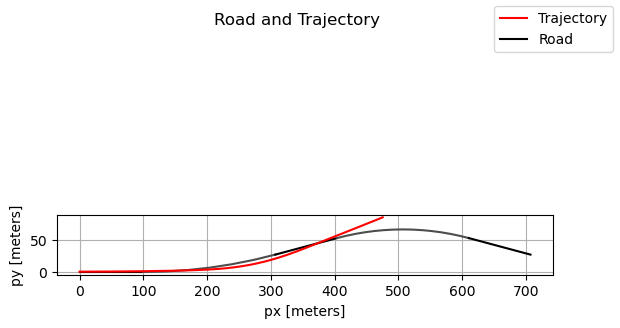

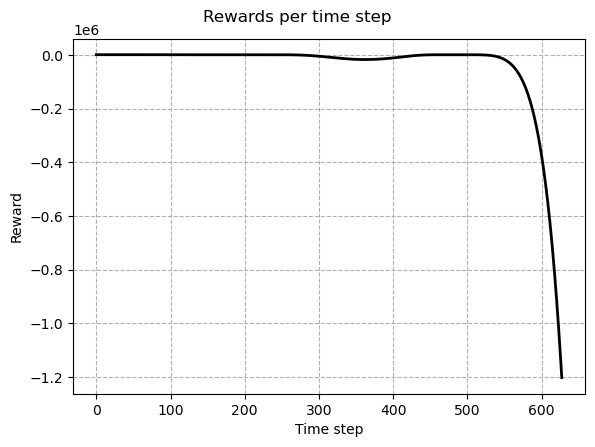

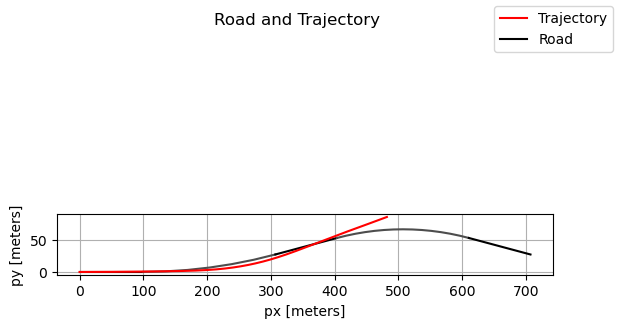

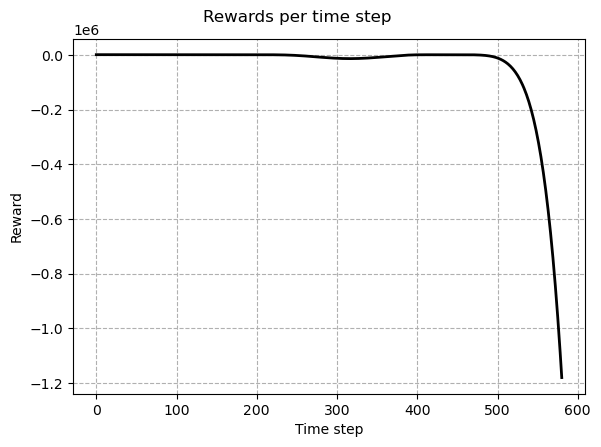

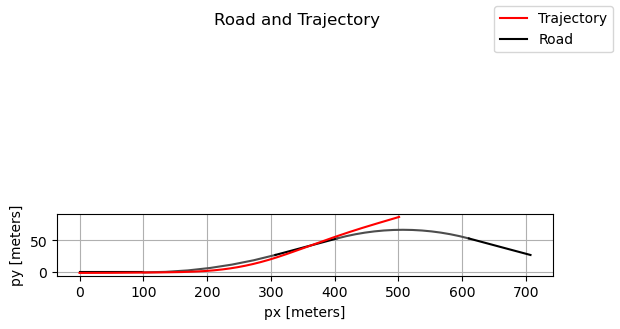

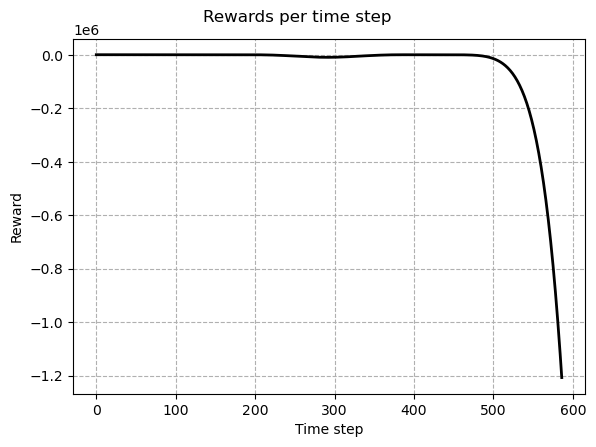

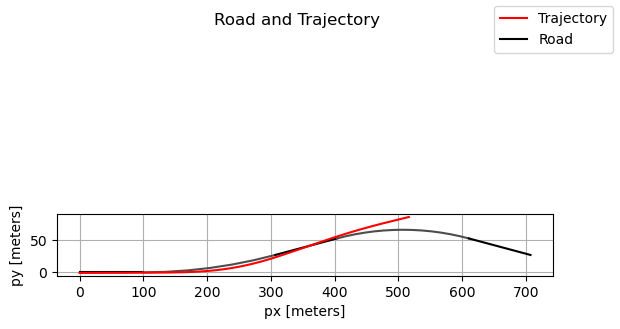

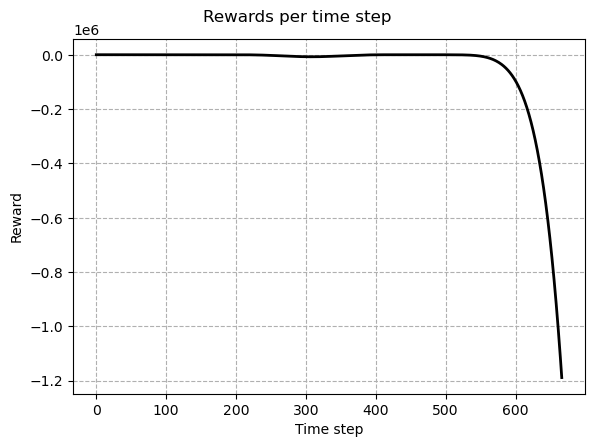

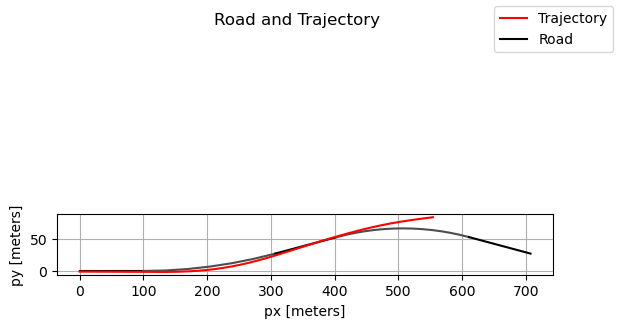

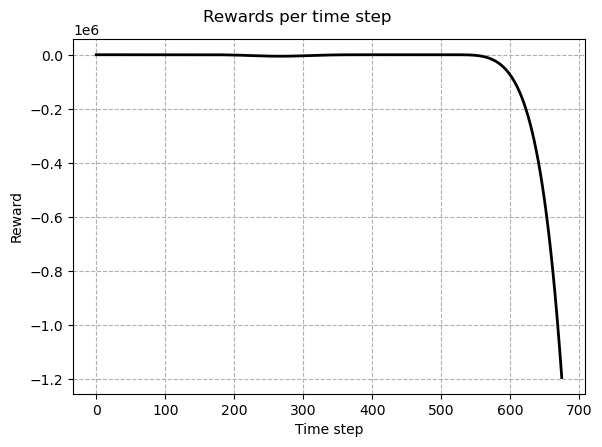

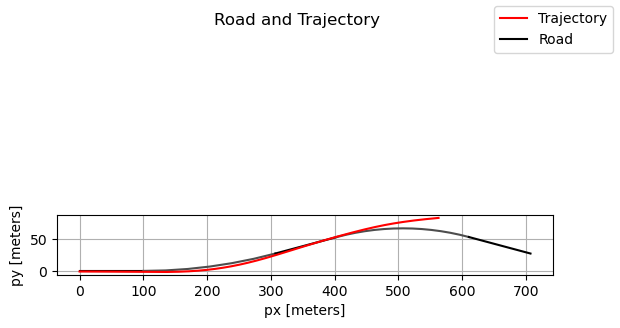

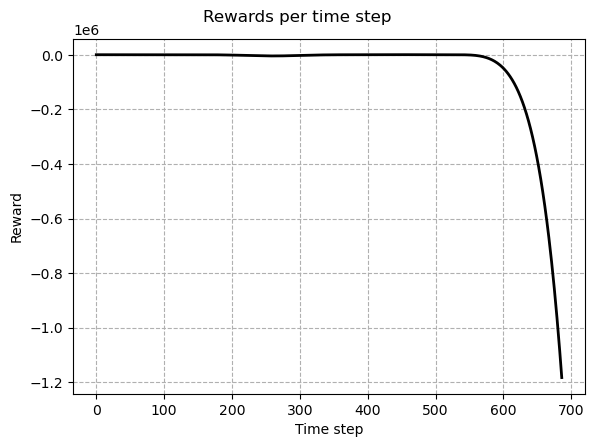

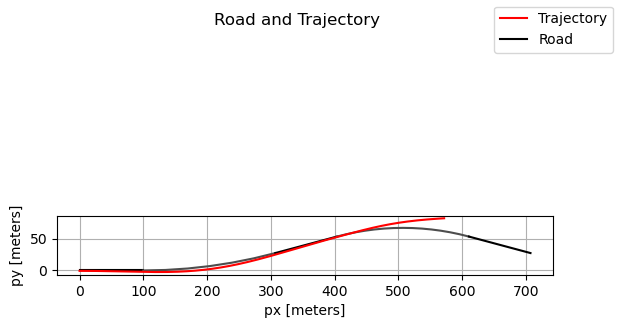

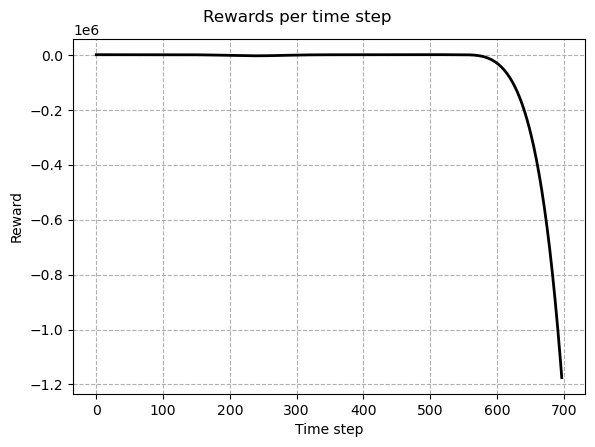

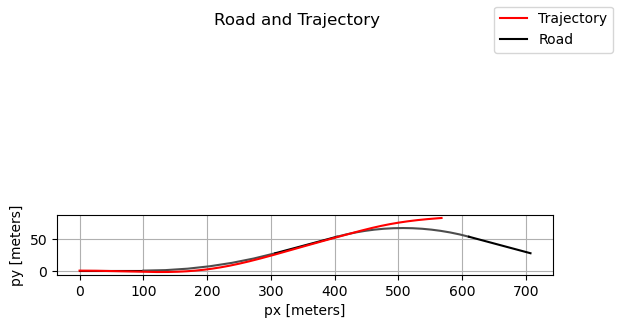

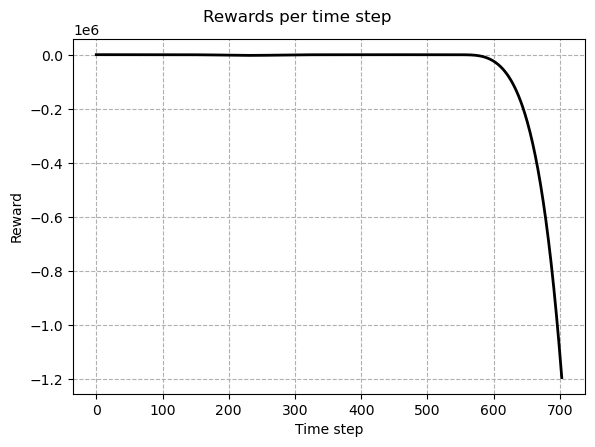

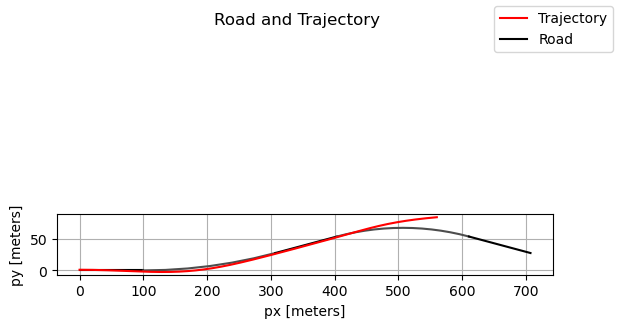

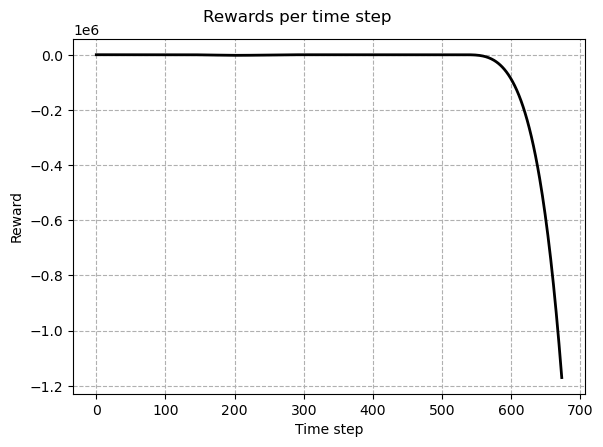

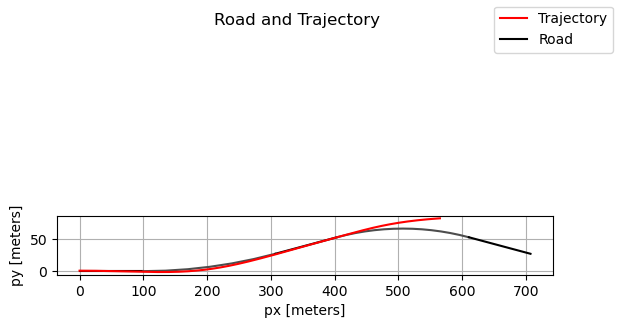

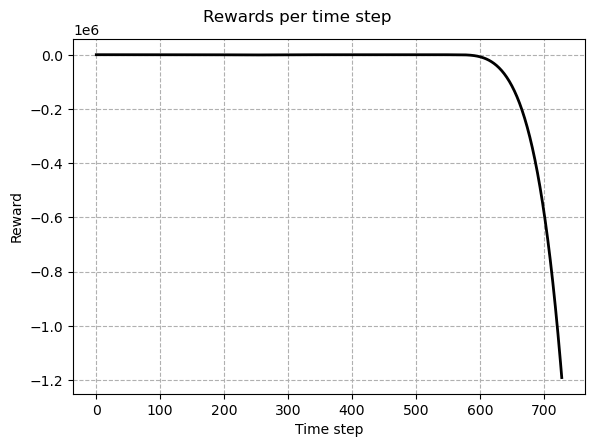

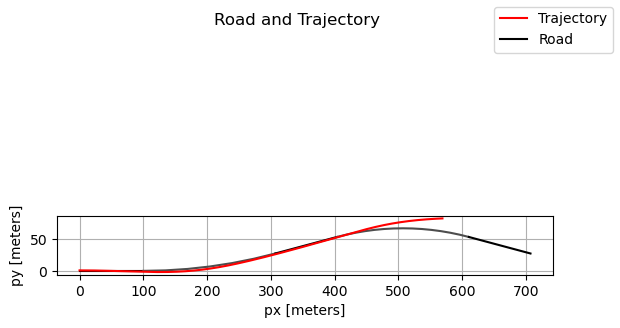

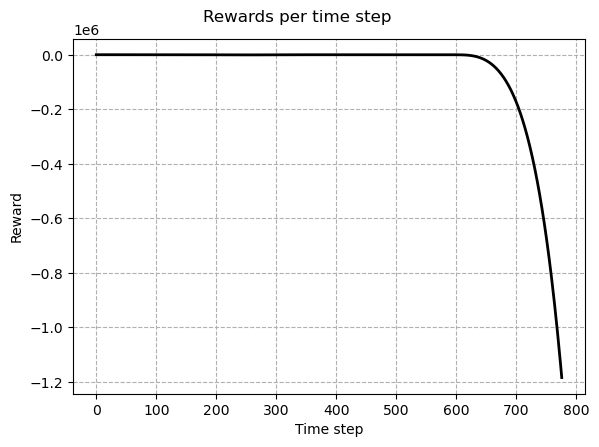

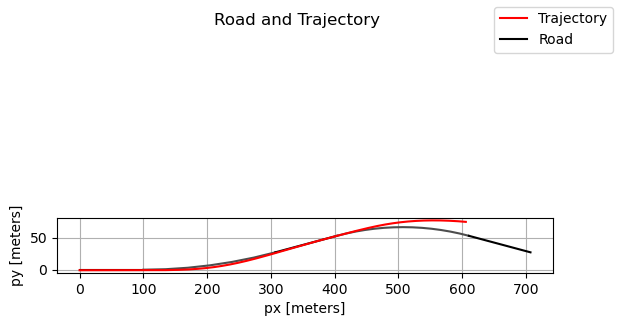

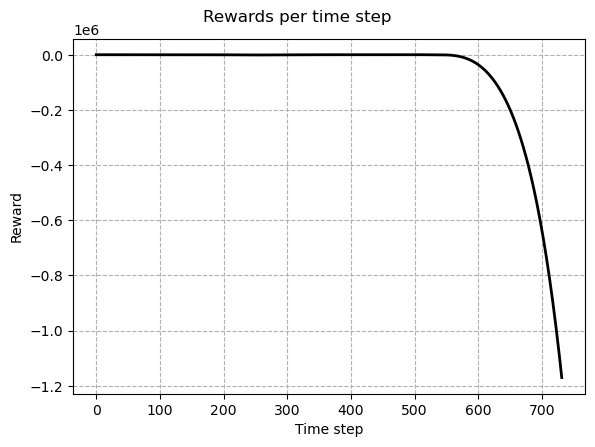

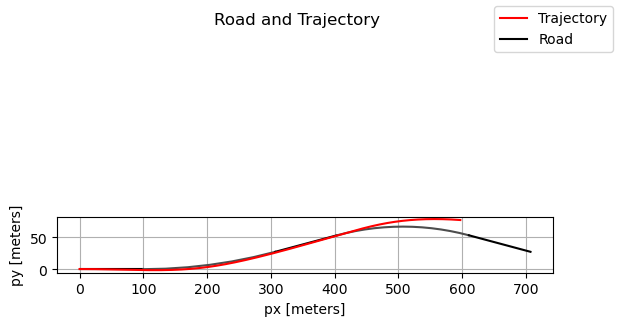

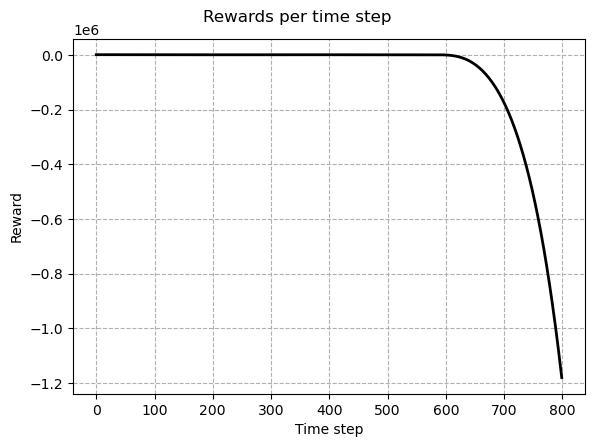

In [20]:
model = PPO("MultiInputPolicy", env, verbose = 1, tensorboard_log=logdir)
epoch = 1
N_EPOCHS = 20

for i in range(epoch, N_EPOCHS + 1):
    model.learn(
        total_timesteps=TIMESTEPS_PER_EPOCH,
        reset_num_timesteps=False,
        tb_log_name=f"{model_name}"
    )
    model.save(f"{models_dir}/{TIMESTEPS_PER_EPOCH * i}")
    eval_model(env, model, figs_dir, TIMESTEPS_PER_EPOCH * i)
    epoch += 1

## Evaluating the Policy

/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.current_ground_truth to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.current_ground_truth` for environment variables or `env.get_wrapper_attr('current_ground_truth')` that will search the reminding wrappers.
  logger.warn(
/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.car to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.car` for environment variables or `env.get_wrapper_attr('car')` that will search the reminding wrappers.
  logger.warn(




Now starting simulation.
Simulation finished


Saved results CSV: models/PPO/eval/internal_policies_results.csv
Saved figure: models/PPO/eval/ad_cartesian_coords_internal_policies.pdf
Saved figure: models/PPO/eval/ad_time_series_internal_policies.pdf
Total progress along road: 604.09 m
Mean |distance to line|: 3.757 m
Mean speed: 56.22 km/h


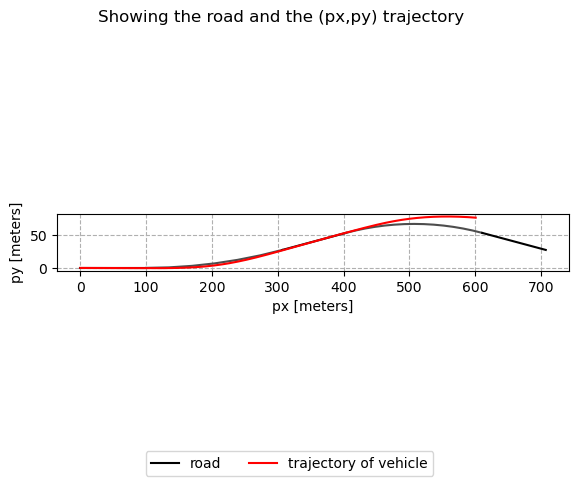

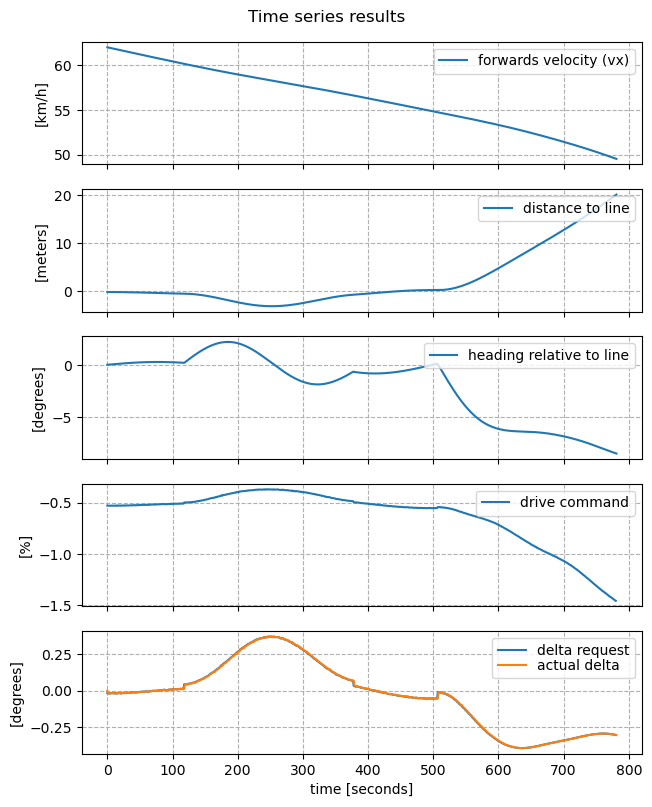

In [22]:
from evaluation.evaluation_for_autonomous_driving import simulate_policy, plot_results_from_time_series_dict
from policies.rl_policy import RLPolicy
import os

def save_time_series_csv(path, filename, results):
    os.makedirs(path, exist_ok=True)
    fpath = os.path.join(path, filename)

    # Build a simple CSV with key signals for tuning
    headers = [
        "time_index",
        "time_in_seconds",
        "road_progress_at_closest_point",
        "distance_to_closest_point",
        "vx",
        "drive_command",
        "delta_request",
    ]

    # The evaluation helper exposes arrays with length N+1
    ti = np.asarray(results["time_index"]).flatten()
    ts = np.asarray(results["time_in_seconds"]).flatten()
    prog = np.asarray(results["road_progress_at_closest_point"]).flatten()
    dist = np.asarray(results["distance_to_closest_point"]).flatten()
    vx = np.asarray(results["vx"]).flatten()
    dc = np.asarray(results["drive_command"]).flatten()
    dr = np.asarray(results["delta_request"]).flatten()

    data = np.stack([ti, ts, prog, dist, vx, dc, dr], axis=1)

    # Write CSV
    with open(fpath, "w") as f:
        f.write(",".join(headers) + "\n")
        np.savetxt(f, data, delimiter=",", fmt="%.6f")
    print(f"Saved results CSV: {fpath}")


## -----------------
#  SIMULATE RL MODEL
#  -----------------
def simulate_rl_model(env, N_sim, rl_model, seed=None, should_save_look_ahead_results=False, should_save_observations=False, verbose=0):
    # Put the RL model into a policy class
    rl_policy = RLPolicy(rl_model)
    # Call the simluate policy function
    sim_time_series_dict = simulate_policy(env, N_sim, rl_policy, seed, should_save_look_ahead_results, should_save_observations, verbose)
    # Return the results dictionary
    return sim_time_series_dict

save_dir = "models/PPO/eval"
ensure_dir(save_dir)

N_sim = 1500
results = simulate_rl_model(
    env, N_sim, rl_model=model, seed=42, should_save_look_ahead_results=False, should_save_observations=True, verbose=1
)

# Save timeseries to CSV for tuning
save_time_series_csv(save_dir, "internal_policies_results.csv", results)

# Quick trajectory/time-series plots
plot_results_from_time_series_dict(env, results, save_dir, file_name_suffix="internal_policies", should_plot_reward=False)

# Optional: animation (commented to keep example lightweight)
# px, py = results["px"], results["py"]
# theta, delta = results["theta"], results["delta"]
# ani = env.unwrapped.render_matplotlib_animation_of_trajectory(px, py, theta, delta, numerical_integration_parameters["Ts"], traj_increment=3)
# ani.save(os.path.join(save_dir, "internal_policies_animation.gif"))

# Print simple summary metrics
total_progress = np.nanmax(results["road_progress_at_closest_point"]) - np.nanmin(results["road_progress_at_closest_point"])
mean_abs_lat = np.nanmean(np.abs(results["distance_to_closest_point"]))
mean_speed = np.nanmean(results["vx"]) * 3.6
print(f"Total progress along road: {total_progress:.2f} m")
print(f"Mean |distance to line|: {mean_abs_lat:.3f} m")
print(f"Mean speed: {mean_speed:.2f} km/h")
